In [1]:
import random
import numpy as np
import pandas as pd

SEED = 93
np.random.seed(SEED)
random.seed(SEED)

The following code segment was used to sample from the full Yelp reviews data without taking too long:

```python
FULL_SIZE = 6990280
SAMPLE_P = 50000 / FULL_SIZE

yelp_reviews_raw = []
with open("yelp_academic_dataset_review.json", "r") as fp:
    for entry in fp:
        if random.random() <= SAMPLE_P:
            yelp_reviews_raw.append(json.loads(entry))

yelp_reviews_sampled = pd.DataFrame(yelp_reviews_raw)
yelp_reviews_sampled.to_parquet("yelp_sample.parquet", index=False)
```

In [2]:
yelp_reviews_sampled = pd.read_parquet("yelp_sample.parquet")
yelp_reviews_sampled.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,byblHsbxiqb1pC1cuSfslA,C_2mNjl-doRVvsL03_T57Q,18eWJFJbXyR9j_5xfcRLYA,4.0,7,0,0,This is the first time I tried this place and ...,2011-10-28 03:43:05
1,1c6sgLe07HAhipebsQ1wgA,ZRXvbrutBBULaFS6T9NCwA,HnhxO2cpa15AHI1456Pl6Q,5.0,0,1,0,Wow! I never thought my sons phone could be re...,2015-10-17 00:55:35
2,VDn0TqsdpxbNUBZEXkakUQ,16_EZvrDyxjDgxq6OUdbhQ,WaRZsQEcEHwRk0T2dJ-cuA,5.0,1,0,0,"Fabulous! Best happy hour, fresh menu, Delish-...",2014-02-24 03:20:20
3,WaeKsvHUJ8whjBlWjl0kaQ,yyxEa8y4HGij_m7g1wDKWg,Jc6MxMyCLp4DMfN4C1t1aQ,3.0,0,0,0,It's really a run of the middle as far as Cuba...,2015-04-15 14:50:49
4,cApCuVIQdSmCryjmTiSELA,jVMvuv2SlzIf5JOUEbi0tQ,D3DMIr-I0AKzlIKdErxHGg,5.0,4,0,0,Incredible service and incredible food! The bl...,2013-12-29 05:21:36


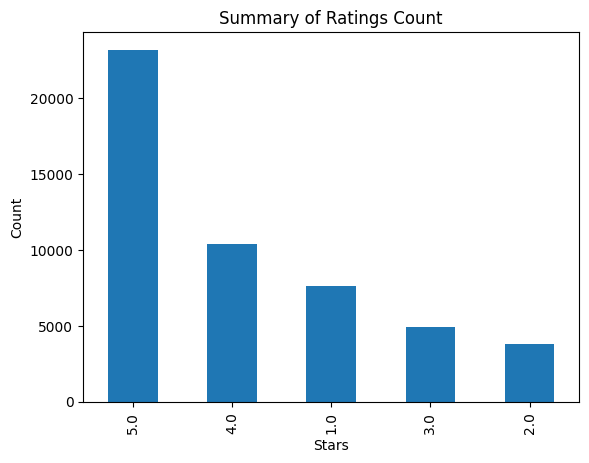

In [3]:
import matplotlib.pyplot as plt

ratings_summary = yelp_reviews_sampled["stars"].value_counts()
ratings_summary.plot.bar()
plt.title("Summary of Ratings Count")
plt.ylabel("Count")
plt.xlabel("Stars")
plt.show()

In [4]:
from datasets import Dataset
from transformers import AutoTokenizer

yelp_reviews_sampled["stars"] = yelp_reviews_sampled.stars.apply(lambda x: int(x) - 1)
yelp_reviews_sampled = yelp_reviews_sampled.rename(columns={"stars": "label"})
yelp_dicts = yelp_reviews_sampled[["text", "label"]].to_dict("records")

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
yelp_dataset = Dataset.from_list(yelp_dicts).map(lambda x: tokenizer(x["text"], truncation=True))
yelp_dataset

Map:   0%|          | 0/49975 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 49975
})

In [5]:
train_testvalid = yelp_dataset.train_test_split(test_size=0.2)
test_valid = train_testvalid["test"].train_test_split(test_size=0.5)
train, valid, test = train_testvalid["train"], test_valid["train"], test_valid["test"]
train

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 39980
})

In [6]:
train.to_parquet("yelp_train.parquet")
valid.to_parquet("yelp_eval.parquet")
test.to_parquet("yelp_test.parquet")

Creating parquet from Arrow format:   0%|          | 0/40 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

6209435